In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [148]:
# HODP colors
monochrome_colors = ['#251616', '#760000', '#C63F3F', '#E28073', '#F1D3CF']
primary_colors = ['#C63F3F', '#F4B436', '#83BFCC', '#455574', '#E2DDDB']

# HODP template
theme_hodp = go.layout.Template(
    layout=go.Layout(
        title = {'font':{'size':24, 'family':"Helvetica", 'color':monochrome_colors[0]}, 'pad':{'t':100, 'r':0, 'b':0, 'l':0}},
        font = {'size':18, 'family':'Helvetica', 'color':'#717171'},
        xaxis = {'ticks': "outside",
                'tickfont': {'size': 14, 'family':"Helvetica"},
                'showticksuffix': 'all',
                'showtickprefix': 'last',
                'showline': True,
                'title':{'font':{'size':18, 'family':'Helvetica'}, 'standoff':20},
                'automargin': True
                },
        yaxis = {'ticks': "outside",
                'tickfont': {'size': 14, 'family':"Helvetica"},
                'showticksuffix': 'all',
                'showtickprefix': 'last',
                'title':{'font':{'size':18, 'family':'Helvetica'}, 'standoff':20},
                'showline': True,
                'automargin': True
                },
        legend = {'bgcolor':'rgba(0,0,0,0)', 
                'title':{'font':{'size':18, 'family':"Helvetica", 'color':monochrome_colors[0]}}, 
                'font':{'size':14, 'family':"Helvetica"}, 
                'yanchor':'bottom'
                },
        colorscale = {'diverging':monochrome_colors},
        coloraxis = {'autocolorscale':True, 
                'cauto':True, 
                'colorbar':{'tickfont':{'size':14,'family':'Helvetica'}, 'title':{'font':{'size':18, 'family':'Helvetica'}}},
                }
    )
)

In [149]:
vdistances = pd.read_csv("geocoded_businesses.csv")
vdistances.head(5)

,Unnamed: 0,Name,Latitude,Longitude,Address,Storefront Sales Status,Sales Options,Grocery Sales,Phone,Website,Facebook,Twitter,Instagram,LastModified
0,0,1369 Coffee House,42.390604,-71.121712,NaN,Open,"Delivery, Take Out",yes,757 Massachusetts Ave,NaN,https://www.facebook.com/1369Coffeehouse/,https://twitter.com/1369coffeehouse?ref_src=tw...,https://www.instagram.com/1369coffeehouse/?hl=en,2020-06-16T17:08:30Z
1,1,1369 Coffee House,42.373793,-71.100367,NaN,Open,"Delivery, Take Out, Outdoor Dining",NaN,1369 Cambridge Street,NaN,https://www.facebook.com/1369Coffeehouse/,https://twitter.com/1369coffeehouse,https://www.instagram.com/1369coffeehouse/?hl=en,2020-07-10T15:24:36Z
2,2,2 4-1 Optical,42.390604,-71.121712,NaN,Open,NaN,NaN,1128 Massachusetts Ave,NaN,https://www.facebook.com/241optical/,NaN,NaN,2020-06-16T17:09:04Z
3,3,5th Street Laundromat,42.369638,-71.083565,NaN,Open,NaN,NaN,58 5th Street,NaN,NaN,NaN,NaN,2020-03-22T12:45:32Z
4,5,730 Tavern,42.366016,-71.105142,NaN,Open,"Delivery, Take Out, Indoor Dining",NaN,730 Massachusetts Ave,NaN,https://www.facebook.com/730tavern/,NaN,https://www.instagram.com/p/B9uqJpAgWJz/,2020-12-15T13:55:02Z


In [150]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [151]:
harv_lat = 42.3744
harv_long = -71.1171
mit_lat = 42.3598
mit_long = -71.0921


harv_dist = np.zeros(np.shape(vdistances)[0])
mit_dist = np.zeros(np.shape(vdistances)[0])
#min_dist = np.zeros(np.shape(vdistances)[0])

for i in range(len(vdistances.index)):
    harv_dist[i] = haversine(harv_long, harv_lat, vdistances["Longitude"][i], vdistances["Latitude"][i])
    mit_dist[i] = haversine(mit_long, mit_lat, vdistances["Longitude"][i], vdistances["Latitude"][i])
    #min_dist[i] = min(vdistances["harv_dist"][i], vdistances["mit_dist"][i])

# impute outliers that api did not pick up coordinates for
harv_dist = np.where(harv_dist < 50, harv_dist, np.median(harv_dist))
mit_dist = np.where(mit_dist < 50, mit_dist, np.median(mit_dist))
#min_dist = np.where(min_dist < 50, min_dist, np.median(min_dist))

vdistances['harv_dist'] = harv_dist
vdistances['mit_dist'] = mit_dist
vdistances['min_dist'] = min_dist
vdistances.head()

vdistances.to_csv("vdistances.csv")

# Clean and group data on open stores

In [152]:
openloc = vdistances[(vdistances["Storefront Sales Status"] == "Open")]
openloc = openloc.reset_index()
closedloc = vdistances[(vdistances["Storefront Sales Status"] == "Closed")]
closedloc = closedloc.reset_index()
#print(openloc['Sales Options'].unique())

# Merge data from two columns for opening info
for i in range(np.shape(openloc)[0]):
    # If value is nan
    if pd.isnull(openloc['Sales Options'][i]):
        # Check to see if alternate 'adddress' column has info
        if (openloc['Address'].loc[i]) != np.nan:
            openloc['Sales Options'].loc[i] = openloc['Address'].loc[i]

# Remove places without info and outliers that simply won't go away
openloc_clean = openloc[(openloc['Sales Options'].notnull())]
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Diaper Lab']
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Sulmona']
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Craigie on Main']
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Longfellow Bar']
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Royal East']
openloc_clean = openloc_clean[openloc_clean['Name'] != 'Café Luna']
openloc_clean = openloc_clean.reset_index()

/home/johnattan/.local/share/virtualenvs/CS109a-LuRlfjbh/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [174]:
# Group together categories

# Delivery
# Takout
# Dine in

print(openloc_clean['Sales Options'].unique())

takeout = ['Take Out', 'takeout', 'Pickup', 'Online Sales, Pickup', 'Delivery', 'Online Sales' ,'Delivery, Online Sales', 'Delivery, Online Sales, Pickup', 'delivery', 'Delivery, Pickup']
dinein = ['Indoor Dining', 'Outdoor Dining', 'Outdoor Dining, Indoor Dining', 'dinein']
takeout_dinein = ['Take Out, Outdoor Dining', 'Take Out, Indoor Dining','Take Out, Outdoor Dining, Indoor Dining', 'Delivery, Outdoor Dining, Indoor Dining']
del_din_takeout = ['Delivery, Take Out, Outdoor Dining', 'Delivery, Take Out, Indoor Dining', 'Delivery, Take Out, Outdoor Dining, Indoor Dining']

for i in range(np.shape(openloc_clean)[0]):
    if openloc_clean['Sales Options'][i] in takeout:
        openloc_clean['Sales Options'][i] = 'Take Out'
    elif openloc_clean['Sales Options'][i] in dinein:
        openloc_clean['Sales Options'][i] = 'Dine in'
    elif openloc_clean['Sales Options'][i] in del_din_takeout:
        openloc_clean['Sales Options'][i] = 'Delivery, Dine in, Takeout'
    elif openloc_clean['Sales Options'][i] in takeout_dinein:
        openloc_clean['Sales Options'][i] = 'Takeout, Dine in'




['Delivery, Take Out' 'Delivery, Dine in, Takeout' 'Take Out'
 'Takeout, Dine in' 'Dine in' 'Delivery, Pickup']


<ipython-input-174-892202d49229>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



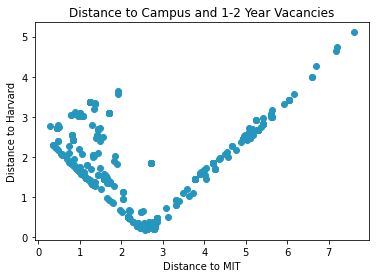

In [154]:
plt.scatter(openloc["mit_dist"],openloc["harv_dist"],c='#2596be')
plt.xlabel("Distance to MIT")
plt.ylabel("Distance to Harvard")
plt.title("Distance to Campus and 1-2 Year Vacancies")
plt.show()

In [155]:
openmin = []
openmin = np.append (openmin, (vdistances.loc[vdistances["Storefront Sales Status"]== "Open"]["min_dist"]))
closedmin=[]
closedmin=np.append (openmin, (vdistances.loc[vdistances["Storefront Sales Status"]== "Closed"]["min_dist"]))
openY=[]
closedY=[]

openY = np.ones((len(openmin),), dtype=int)
closedY = np.zeros((len(closedmin),),dtype=int)

closedminfinal=[]
for i in range(len(closedmin)):
    if closedmin[i]<5:
        closedminfinal.append(closedmin[i])
openminfinal=[]
for i in range(len(openmin)):
    if openmin[i]<5:
        openminfinal.append(openmin[i])


In [ ]:

import plotly.express as px

harv_lat = 42.3744
harv_long = -71.1171
mit_lat = 42.3598
mit_long = -71.0921

data = [[42.3744, -71.1171, 'Harvard'], [42.3598, -71.0921, 'MIT']]

locations = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'location name'])
print(locations)

   Latitude  Longitude location name
0   42.3744   -71.1171       Harvard
1   42.3598   -71.0921           MIT


In [177]:


fig = px.scatter(openloc_clean, x='Longitude', y='Latitude', color='Sales Options', 
        size=np.repeat(2, np.shape(openloc_clean)[0]), opacity=0.7, hover_data=['Name'])

fig.add_scatter(x=[harv_long], y=[harv_lat], mode='markers', marker=dict(size=150, color=['crimson'], opacity=0.4), 
        hovertext=['Harvard'], name="Harvard")

fig.add_scatter(x=[mit_long], y=[mit_lat], mode='markers', marker=dict(size=150, color=['seagreen'], opacity=0.4), 
        hovertext=['MIT'], name="MIT")

fig.show()

fig.write_json('sales_options_plot.json')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cf414bac-1baa-463f-8d73-f1d9a87e25d5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>